## Linear Regression MNIST.py Test

This section is for testing provided Linear Regression MNIST.py script.

In [1]:
###############################################
# MNIST Image Classification Using Linear Regression
# 
################################################
# 1.1 Load the libraries
#
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

print(tf.__version__)

1.12.0


In [2]:
#######################################################
# 1.2 Download and read MNIST data
#
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("MNIST_data/", one_hot = True)
print()
print("The Training Set is:")
print(data.train.images.shape)
print(data.train.labels.shape)
print()
print("The Test Set is:")
print(data.test.images.shape)
print(data.test.labels.shape)
print()
print("The Validation Set is:")
print(data.validation.images.shape)
print(data.validation.labels.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

The Training Set is:
(55000, 784)
(55000, 10)

The Test Set is:
(10000, 784)
(10000, 10)

The Validation Set is:
(5000, 784)
(5000, 10)


In [3]:
#######################################################
# the images are stored in one-dimensional arrays of this length.
#
img_size_flat = data.train.images[0].shape[0]

# Tuple with height and width of images used to reshape arrays.
img_shape = (28,28)

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [4]:
#####################################################
# 1.3 One hot encoding
#
print('One hot encoding label:')
print(data.test.labels[0:5,:])
print()

data.test.cls = np.array([label.argmax() for label in data.test.labels])

print('Real label:')
print(data.test.cls[0:5])

One hot encoding label:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

Real label:
[7 2 1 0 4]


In [5]:
########################################################
# 1.4 Function to plot images
#
def plot_images(images, cls_true , cls_pred=None):
  assert len(images) == len(cls_true) == 9
  
  # Create figure with 3x3 subplots.
  fig, axes = plt.subplots(3,3)
  fig.subplots_adjust(hspace=0.3, wspace=0.3)
  
  for i, ax in enumerate(axes.flat):
    # Plot image.
    ax.imshow(images[i].reshape(img_shape), cmap='binary')
    
    # Show true and predicted classes
    if cls_pred is None:
      xlabel = 'True : {0}'.format(cls_true[i])
    else:
      xlabel = 'True : {0}, Pred : {1}'.format(cls_true[i], cls_pred[i])
      
    ax.set_xlabel(xlabel)
    
    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])
    
  # Ensure the plot is shown correctly with multiple plots
  # in a single Notebook cell.
  plt.show()

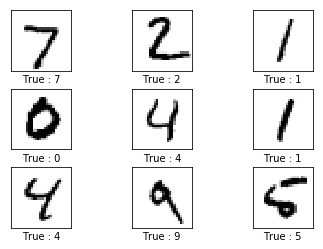

In [6]:
###########################################
# 1.5 Plot a few images
# Get the first images from the Test-set.
#   
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = [np.argmax(oh) for oh in data.test.labels[0:9] ]

# Plot the images and labels using our helper-function above.
plot_images(images, cls_true)

In [7]:
##############################################
# 2.1 Placeholder variables
#
x = tf.placeholder( tf.float32, [None, img_size_flat])

y_true = tf.placeholder( tf.float32, [None, num_classes])

y_true_cls = tf.placeholder( tf.int64, [None])

##############################################
# 2.2 Variables
#
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

bias = tf.Variable(tf.zeros([num_classes]))

###############################################
# 2.3 Model
#
logits = tf.matmul(x, weights) + bias

y_pred = tf.nn.softmax(logits)

y_pred_cls = tf.argmax(y_pred, axis=1)

###############################################
# 2.4 Cost Function
#
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2( logits= logits, labels = y_true)
cost = tf.reduce_mean(cross_entropy)

################################################
# 2.5 Optimization Function
#
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

#############################################
# 2.6 Performance measures
#
correct_prediction = tf.equal( y_pred_cls , y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
##############################################
# 3.1 Create TensorFlow Session
#
session = tf.Session()

#############################################
# 3.2 Initialize Variables
#
session.run(tf.global_variables_initializer())

###########################################
# 3.3 Function to perform optimization iteration
#
batch_size = 100

def optimize(num_iterations):
  for i in range(num_iterations):
    # Get a batch of training examples.
    # x_batch now holds a batch of images and
    # y_true_batch are the true labels for those images.
    x_batch, y_true_batch = data.train.next_batch(batch_size= batch_size)
    
    # Put the batch into a dict with the proper names
    # for placeholder variables in the TensorFlow graph.
    # Note that the placeholder for y_true_cls is not set
    # because it is not used during training.
    feed_dict_train = {x : x_batch,
                       y_true : y_true_batch}
    
    # Run the optimizer using this batch of training data.
    # TensorFlow assigns the variables in feed_dict train
    # to the placeholder variables and then runs the optimizer.
    session.run(optimizer, feed_dict = feed_dict_train)

###################################################
# 3.4 Optimization Iteration
#
feed_dict_test = { 
                   x : data.test.images,
                   y_true : data.test.labels,
                   y_true_cls : [np.argmax(label) for label in data.test.labels]
                  }

def print_accuracy():
  # Use TensorFlow to compute the accuracy.
  acc = session.run(accuracy , feed_dict= feed_dict_test)
  
  # Print the accuracy.
  print('Accuracy on Test-st : {0:.1%}'.format(acc))
  
def print_confusion_matrix():
  # Get the true classifications for the Test-set.
  cls_true = [np.argmax(label) for label in data.test.labels]
  
  # Get the predicted classifications for the Test-set.
  cls_pred = session.run(y_pred_cls, feed_dict = feed_dict_test)
  
  # Get the confusion matrix using sklearn.
  cm = confusion_matrix(y_true = cls_true, 
                        y_pred = cls_pred)
  
  # Print the confusion matrix as text.
  print(cm)
  
  # Plot the confusion matrix as an image.
  plt.imshow(cm, interpolation ='nearest', cmap = plt.cm.Blues)
  
  # Make various adjustments to the plot.
  plt.tight_layout()
  plt.colorbar()
  tick_marks = np.arange(num_classes)
  plt.xticks(tick_marks, range(num_classes))
  plt.yticks(tick_marks, range(num_classes))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  
  # Ensure the plot is shown correctly with multiple plots
  # in a single Notebook cell.
  plt.show()
  
def plot_example_errors():
  # Use TensforFlow to get a list of boolean values
  # whether each test-image has been correctly classified,
  # and a list for the predicted class of each image.
  correct, cls_pred = session.run([correct_prediction,
                                   y_pred_cls],
                                   feed_dict = feed_dict_test)
  
  # Negate the boolean array.
  incorrect = (correct == False)
  
  # Get the images from the Test-set that have been 
  # incorrectly classified
  images = data.test.images[incorrect]
  
  # Get the predicted classes for those images
  cls_pred = cls_pred[incorrect]
  
  # Get the true classes for those images.
  cls_true = [np.argmax(label) for label in data.test.labels[incorrect]]
  
  # Plot the first 9 images.
  plot_images(images = images[0:9],
              cls_true = cls_true[0:9],
              cls_pred = cls_pred[0:9])

Accuracy on Test-st : 9.8%


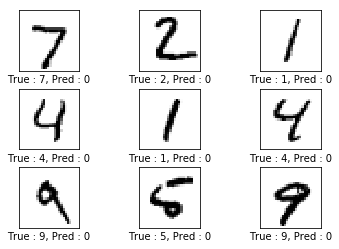

In [9]:
###########################################
# 4.1 Performance before any optimization
#
print_accuracy()

plot_example_errors()

Accuracy on Test-st : 36.3%


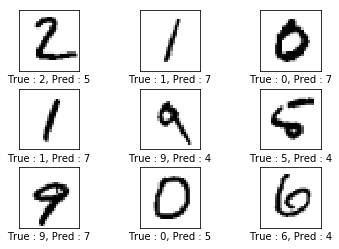

In [10]:
#############################################
# 4.2 Performance Iteration#1
#
# Number of iteration means how many of batchs are iterated
optimize(num_iterations= 1)

print_accuracy()

plot_example_errors()

Accuracy on Test-st : 76.0%


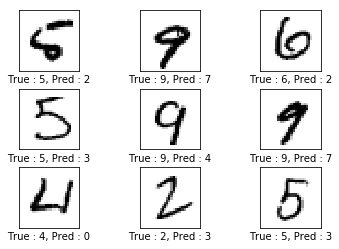

In [11]:
###############################################
# 4.3 Performance Iteration #10
# We've already performed 1 iteration.
optimize( num_iterations=9 )

print_accuracy()

plot_example_errors()

Accuracy on Test-st : 91.9%


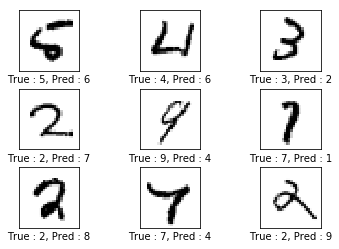

In [12]:
#################################################
# 4.4 Performance Iteration #1000
# We've already performed 10 iterations.
optimize(num_iterations=990)

print_accuracy()

plot_example_errors()

[[ 953    0    2    2    0   10    8    2    3    0]
 [   0 1109    2    2    0    3    4    1   14    0]
 [   5    7  915   20    9    4   11   10   42    9]
 [   3    1   16  923    0   29    1    8   17   12]
 [   1    2    3    1  909    1   11    2   12   40]
 [   7    3    4   38    8  781   13    4   27    7]
 [  11    3    4    2    9   21  902    2    4    0]
 [   1   13   22    9    7    2    0  926    3   45]
 [   3   10    6   24    8   41    8    4  855   15]
 [   9    8    2   12   32   10    0   12    9  915]]


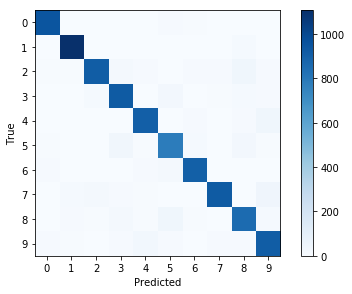

In [13]:
###################################################
# 4.5 Print confusion Matrix
#
print_confusion_matrix()

## HW1

### HW1.1 Learning Rate

The code and the plot are shown as follows. We can see that the rate of convergence is similar among different learning rates. However, the converged accuracy slightly increases with the learning rate, sicne we can see that learning rate = 0.1 gives lowest accuracy. Note the optimizer is Gradient Descent optimizer and the bacth size is 100.

Learning rate = 0.5
Learning rate = 0.4
Learning rate = 0.3
Learning rate = 0.2
Learning rate = 0.1


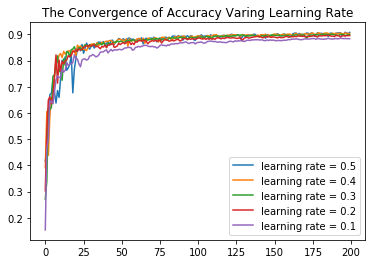

In [14]:
acc_list = []
lr_list = np.arange(0.5,0,-0.1)

for i,lr in enumerate(lr_list):
    print('Learning rate = %.1f'%lr_list[i])
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
    
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    batch_size = 100
    acc_list.append([])
    for iterate in range(200):
        optimize(num_iterations= 1)
        acc = session.run(accuracy , feed_dict= feed_dict_test)
        acc_list[i].append(acc)

for i in range(5):
    plt.plot(range(200),acc_list[i],label='learning rate = %.1f'%lr_list[i])
    plt.legend()
    plt.title('The Convergence of Accuracy Varing Learning Rate')

### HW1.2 Optimizer

The code and the plot are shown as follows. We can see that the rate of convergence: Adam optimizer > Adagrad Optimizer > Gradient Descent Optimizer. Note the learning rate is 0.05 and the bacth size is 100.

Optimizer = Gradient Descent Optimizer
Optimizer = Adagrad Optimizer
Optimizer = Adam Optimizer


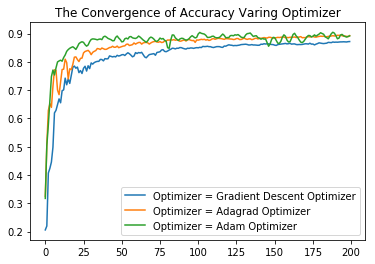

In [15]:
acc_list = []
lr = 0.05
optimizer1 = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
optimizer2 = tf.train.AdagradOptimizer(learning_rate=lr).minimize(cost)
optimizer3 = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
optimizer_list = ['Gradient Descent Optimizer','Adagrad Optimizer','Adam Optimizer']

for i,optimizer in enumerate([optimizer1,optimizer2,optimizer3]):
    print('Optimizer = %s'%optimizer_list[i])
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    batch_size = 100
    acc_list.append([])
    for iterate in range(200):
        optimize(num_iterations= 1)
        acc = session.run(accuracy , feed_dict= feed_dict_test)
        acc_list[i].append(acc)

for i in range(3):
    plt.plot(range(200),acc_list[i],label='Optimizer = %s'%optimizer_list[i])
    plt.legend()
    plt.title('The Convergence of Accuracy Varing Optimizer')

### HW1.3 Batch Size

The code and the plot are shown as follows. We can see that the rate of convergence increase with the batch size. Note the optimizer is Gradient Descent optimizer and the learning rate is 1.

Batch size = 1
Batch size = 101
Batch size = 201
Batch size = 301
Batch size = 401
Batch size = 501
Batch size = 601
Batch size = 701
Batch size = 801
Batch size = 901
Batch size = 1001


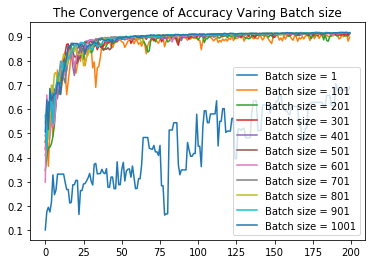

In [16]:
acc_list = []
batch_list = range(1,1002,100)

for i,batch_size in enumerate(batch_list):
    print('Batch size = %d'%batch_list[i])
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1).minimize(cost)
    
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    acc_list.append([])
    for iterate in range(200):
        optimize(num_iterations= 1)
        acc = session.run(accuracy , feed_dict= feed_dict_test)
        acc_list[i].append(acc)

for i in range(11):
    plt.plot(range(200),acc_list[i],label='Batch size = %d'%batch_list[i])
    plt.legend()
    plt.title('The Convergence of Accuracy Varing Batch size')

## HW2

### Scipy

In [17]:
from scipy import signal as sg

I = [[97,52,99,62,69,45,70],
     [99,14,60,50,74,45,22],
     [59,72,74,14,74,100,28],
     [28,8,47,85,2,88,77],
     [74,6,30,87,49,22,43],
     [86,87,4,53,36,10,46],
     [54,7,67,23,29,26,15]]

g = [[1,2,1],[2,4,2],[1,2,1]]

print('Full mode convolution:\n',sg.convolve(I,g))
print()
print('Valid mode convolution:\n',sg.convolve(I,g,'valid'))

Full mode convolution:
 [[  97  246  300  312  292  245  229  185   70]
 [ 293  704  787  808  818  733  644  459  162]
 [ 354  860  951  914  936  993  903  519  142]
 [ 245  656  832  839  805  944 1045  643  155]
 [ 189  472  575  761  867  823  948  748  225]
 [ 262  631  587  641  871  726  629  560  209]
 [ 300  787  779  613  687  584  436  368  150]
 [ 194  489  534  476  430  349  294  214   76]
 [  54  115  135  164  142  107   96   56   15]]

Valid mode convolution:
 [[ 951  914  936  993  903]
 [ 832  839  805  944 1045]
 [ 575  761  867  823  948]
 [ 587  641  871  726  629]
 [ 779  613  687  584  436]]


### Tensorflow

In [18]:
import tensorflow as tf

input_list = tf.constant([
    [97.,52,99,62,69,45,70],
    [99,14,60,50,74,45,22],
    [59,72,74,14,74,100,28],
    [28,8,47,85,2,88,77],
    [74,6,30,87,49,22,43],
    [86,87,4,53,36,10,46],
    [54,7,67,23,29,26,15]])
input = tf.reshape(input_list,[1,7,7,1])

filter_list = tf.constant([[1.,2,1],[2,4,2],[1,2,1]])
filter = tf.reshape(filter_list,[3,3,1,1])

op1 = tf.nn.conv2d(input,filter,strides=[1,1,1,1],padding='SAME')
op2 = tf.nn.conv2d(input,filter,strides=[1,1,1,1],padding='VALID')

with tf.Session() as sess:
    print('Full mode convolution:\n',sess.run(op1))
    print()
    print('Valid mode convolution:\n',sess.run(op2))

Full mode convolution:
 [[[[ 704.]
   [ 787.]
   [ 808.]
   [ 818.]
   [ 733.]
   [ 644.]
   [ 459.]]

  [[ 860.]
   [ 951.]
   [ 914.]
   [ 936.]
   [ 993.]
   [ 903.]
   [ 519.]]

  [[ 656.]
   [ 832.]
   [ 839.]
   [ 805.]
   [ 944.]
   [1045.]
   [ 643.]]

  [[ 472.]
   [ 575.]
   [ 761.]
   [ 867.]
   [ 823.]
   [ 948.]
   [ 748.]]

  [[ 631.]
   [ 587.]
   [ 641.]
   [ 871.]
   [ 726.]
   [ 629.]
   [ 560.]]

  [[ 787.]
   [ 779.]
   [ 613.]
   [ 687.]
   [ 584.]
   [ 436.]
   [ 368.]]

  [[ 489.]
   [ 534.]
   [ 476.]
   [ 430.]
   [ 349.]
   [ 294.]
   [ 214.]]]]

Valid mode convolution:
 [[[[ 951.]
   [ 914.]
   [ 936.]
   [ 993.]
   [ 903.]]

  [[ 832.]
   [ 839.]
   [ 805.]
   [ 944.]
   [1045.]]

  [[ 575.]
   [ 761.]
   [ 867.]
   [ 823.]
   [ 948.]]

  [[ 587.]
   [ 641.]
   [ 871.]
   [ 726.]
   [ 629.]]

  [[ 779.]
   [ 613.]
   [ 687.]
   [ 584.]
   [ 436.]]]]


## HW3

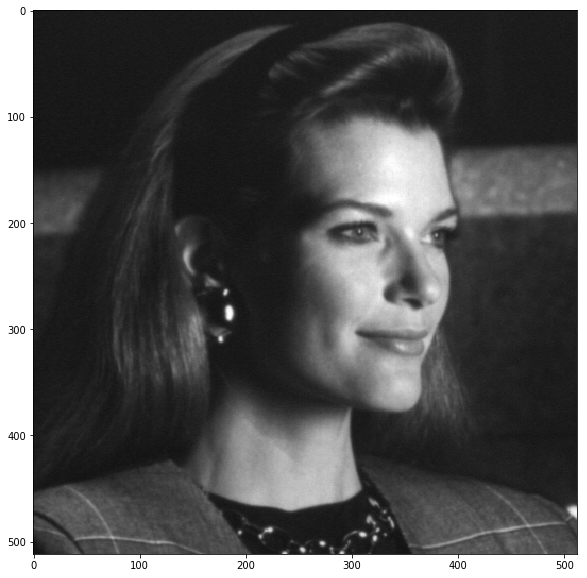

In [19]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from PIL import Image

im = Image.open('01 Lady.png')
fig,ax = plt.subplots(figsize = (10,10))
ax.imshow(im, cmap='gray')
plt.show()

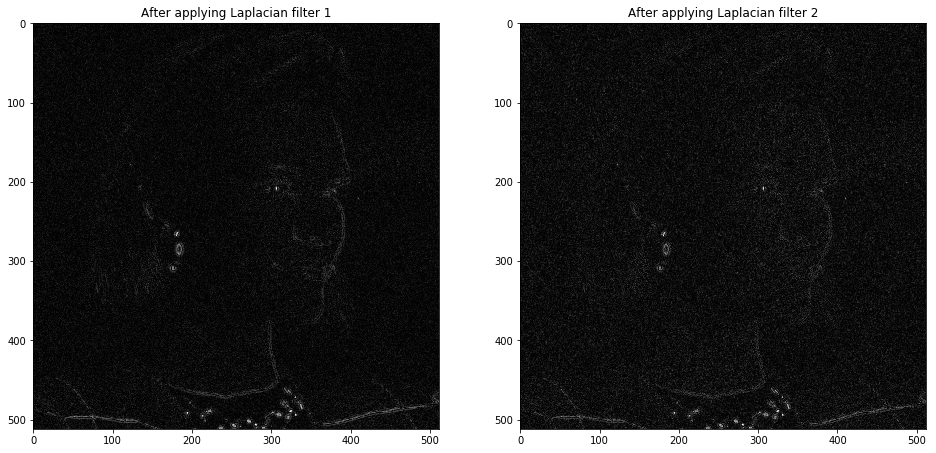

In [20]:
image_gr = im.convert("L")
arr = np.asarray(image_gr)

kernel1 = np.array([[0,1,0],[1,-4,1],[0,1,0]])
kernel2 = np.array([[1,1,1],[1,-8,1],[1,1,1]])

grad1 = signal.convolve2d(arr,kernel2,mode='same',boundary='symm')
grad2 = signal.convolve2d(arr,kernel1,mode='same',boundary='symm')

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,8))
ax1.imshow(np.absolute(grad1), cmap='gray')
ax1.set_title('After applying Laplacian filter 1')
ax2.imshow(np.absolute(grad2), cmap='gray')
ax2.set_title('After applying Laplacian filter 2')
plt.show()